# Certificate Characteristics

#### Determining maliciousness from web certificates proved very useful with other intern models reaching 88% accuracy.  While those schemes were based on the presence or absence of data, this document strived to pull more information from the original feature set.  Unfortunately, this didn't yield impressive results and was actually less effective than the more rudimentary techniques

#### ** Look for places to load in serialized data as it will save a significant amount of time

### Parse Data

In [1]:
import json
import time
import random
import re
import os
import pickle
import datetime
import operator

import numpy as np
import pandas as pd
from pprint import pprint
from collections import defaultdict
from scipy.stats import chisquare
import multiprocessing as mp
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import chi2

#### Create dataframe from scratch

In [ ]:
## Enumerate all files with pertinent data
everyFile=[]
tmp=os.listdir('/data/data/')
tmp.remove('newbenigndata')
for x in tmp:
    try:
        folder='/data/data/'+x+'/enrichment/cert_info/'
        for y in os.listdir(folder):
            if (len(y) > 15):
                everyFile.append(folder+y)
    except:
        continue
        
print(len(everyFile))
        
for x in os.listdir('/data/data/newNONTORbenigndata/enrichment/cert_info/'):
        everyFile.append('/data/data/newNONTORbenigndata/enrichment/cert_info/'+x)

print(len(everyFile))

#### Update existing dataframe with a new files

In [ ]:
everyFile=[]
tmp=os.listdir('/data/data/')
for x in tmp[-10:-3]:
    try:
        folder='/data/data/'+x+'/enrichment/cert_info/'
        for y in os.listdir(folder):
            everyFile.append(folder+y)
    except:
        continue

#### Iterate over files to parse data

In [ ]:
df_cols=['benign', 'indicator', 'error_type', 'cert_validation', 'success', 
         'authorityInfoAccess', 'basicConstraints', 'certificatePolicies',
         'has_expired', 'notAfter', 'notBefore']

col_check=set(df_cols)
error_types=defaultdict(int)
validation_types=defaultdict(int)
usage_types=defaultdict(int)
issuers=defaultdict(int)
ctr=0
lamow=[]
for x in everyFile:
    ctr+=1
    if (ctr % 170 == 0):
        print(ctr/340,'%')
    try:
        book=json.load(open(x))['data']
        for cert_dict in book:
            df=pd.DataFrame(columns=df_cols)
            df['benign']=[len(x)-x.rfind('/')<15]
            infoString=None  
            if (cert_dict.get('cert_info') == None):
                infoString='certificate_info'
            else:
                infoString='cert_info'
                
            if (type(cert_dict[infoString]) != dict):
                df['indicator']=[cert_dict['indicator']]
                df['success']=[cert_dict['success']]
                #try:
                    #df['error_type']=re.findall("\[.*\]",cert_dict[infoString])[0]
                #except Exception as s:
                df['error_type']=[cert_dict[infoString]]
                
                error_types[df['error_type'][0]]+=1

            else:
                df['indicator']=[cert_dict['indicator']]
                df['success']=[cert_dict['success']]
                df['cert_validation'] = [cert_dict.get('cert_validation')]
                
                #try:
                    #validation_types[re.findall("\[.*\]",cert_dict.get('cert_validation'))[0]]+=1
                #except:
                validation_types[df['cert_validation'][0]]+=1
                    
                if (cert_dict[infoString].get('subject') != None):
                    alpha=cert_dict[infoString]['subject'].get('CN',' ')+cert_dict[infoString].get('subjectAltName','')
                    df['subject_len']=len(cert_dict[infoString]['subject'])
                    df['subject_match'] = [alpha.find(cert_dict['indicator']) != -1]
                    df['alt_subjects'] = [alpha.count(',')]
                    
                df['issuer']=cert_dict[infoString].get('issuer',{}).get('CN')
                df['issuer_len']=len(cert_dict[infoString].get('issuer',{}))
                issuers[df['issuer'][0] or '']+=1
                df['keyUsage']=[cert_dict[infoString].get('keyUsage','').split(',')]
                df['extendedKeyUsage']=[cert_dict[infoString].get('extendedKeyUsage','').split(',')]
                for yy in df['keyUsage'][0]:
                    usage_types[yy]+=1
                
                for q in cert_dict[infoString]:
                    if (q in col_check):
                        df[q]=[cert_dict[infoString][q]]
                        
            lamow.append(df)
    except Exception as e:
        #print(e)
        continue
        

In [ ]:
df=pd.concat(lamow,axis=0)
del lamow
def convertToDt(date_string):
    try:
        if (type(date_string) != float):
            return datetime.datetime.strptime(date_string,'%Y/%m/%d %H:%M.%S')
        else:
            return None
    except Exception as e:
        print(date_string)
        print(e)
        
df['notAfter']=df['notAfter'].apply(convertToDt)
df['notBefore']=df['notBefore'].apply(convertToDt)
df.reset_index(drop=True,inplace=True)

In [ ]:
## Many duplicate entries due to errors in collection script

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

## Load saved dataframe

In [2]:
df=pd.concat([pickle.load(open('cert_info_full1.pickle','rb')),pickle.load(open('cert_info_full2.pickle','rb')),
              pickle.load(open('cert_info_full3.pickle','rb'))],axis=0)

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

In [15]:
df=pickle.load(open('cert_info.pickle','rb'))
df_temp=pickle.load(open('cert_info_newbenign.pickle','rb'))
df_temp['benign']=True
df=pd.concat([df,df_temp],axis=0)

df=df.drop_duplicates(subset=df.columns.difference(['keyUsage','extendedKeyUsage']))
df.reset_index(drop=True,inplace=True)

In [ ]:
df=df[df.error_type.apply(lambda x: type(x) == float)]
df['benign'].value_counts()

In [ ]:
df=df[df.error_type.apply(lambda x: type(x) == float)]
df

In [17]:
len(df[df['benign'] == False]['error_type'])

432804

In [19]:
sum(df[df['benign'] == False]['error_type'].isna())

64286

## Augment Features

In [ ]:
usage_types=pickle.load(open('usage_types.pickle','rb'))
usage_types={x.strip() for x in usage_types.keys()}

#### Add one-hot encodings for issuers and usage types

In [ ]:
for x in usage_types:
    df.insert(loc=16,column=x,value=np.zeros(shape=[len(df)],dtype=bool))
    
df.drop(columns='',inplace=True)
df.reset_index(drop=True,inplace=True)

In [ ]:
for x in sorted_all:
    df.insert(loc=23,column=x,value=np.zeros(shape=[len(df)],dtype=bool))
    
df.insert(loc=35,column='valid_duration',value=np.zeros(shape=[len(df)]))

for x in error_codes:
    df.insert(loc=35,column=x,value=np.zeros(shape=[len(df)],dtype=bool))

In [ ]:
#for i in range(0, len(df)):
#    if (type(df.loc[i,'keyUsage']) == list):
#        for x in df.loc[i,'keyUsage']:
#            df.loc[i,x.strip()]=True
df

In [ ]:
def oneHotUsageIssue(row):
    global df
    if (type(df.loc[row,'keyUsage']) == list):
        for x in df.loc[row,'keyUsage']:
            df.loc[row,x.strip()]=True
            
    if (not pd.isnull(df.loc[row,'issuer'])):
        issr=df.loc[row,'issuer']
        if issr[0:issr.find(' ')] in sorted_all:
            df.loc[row,issr[0:issr.find(' ')]]=True
            
    if (not pd.isnull(df.loc[row,'notBefore']) and type(df.loc[row,'notAfter']) != float):
        try:
            df.loc[row,'valid_duration']=(df.loc[row,'notAfter']-df.loc[row,'notBefore']).days
        except Exception as e:
            print(e)
            
    if (type(df.loc[row,'cert_validation']) == str):
        if (df.loc[row,'cert_validation'] in error_codes):
            df.loc[row,df.loc[row,'cert_validation']]=True
            
    return df.loc[row]

results=[]
pool = mp.Pool(mp.cpu_count()*2)
results = pool.map_async(oneHotUsageIssue, [x for x in range(0,len(df))])
pool.close()

#### Save augmented feature dataframe

In [ ]:
while(True):
    try:
        df=pd.DataFrame(results.get(0))
        break
    except:
        continue
        
with open('thistookalldaymajordeath.pickle','wb') as output:
    pickle.dump(df,output,pickle.HIGHEST_PROTOCOL)

### Load Augmented feature dataframe

In [3]:
df=pickle.load(open('thistookalldaymajordeath.pickle','rb'))
df=df[df.error_type.apply(lambda x: type(x) == float)]
df['benign'].value_counts()

True     853917
False     64286
Name: benign, dtype: int64

In [ ]:
#temp_df=pd.DataFrame(np.zeros(shape=[len(df),1]),columns=['valid_duration'])

In [ ]:
#for i in range(0, len(df)):
 #   if (not pd.isnull(df.loc[i,'notBefore']) and type(df.loc[i,'notAfter']) != float):
  #      try:
   #         temp_df.loc[i,'valid_duration']=(df.loc[i,'notAfter']-df.loc[i,'notBefore']).days
    #    except:
     #       continue

#df=pd.concat([df,temp_df],axis=1)

In [ ]:
df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage','cert_validation',''])]

#### Clean dataframe

In [4]:
def replaceTFNan(val):
    if (pd.isnull(val)):
        return 0
    elif (val == False):
        return 1
    else:
        return 2
          

df['has_expired']=df['has_expired'].apply(replaceTFNan)
df['subject_match']=df['subject_match'].apply(replaceTFNan)

def replaceCertVal(val):
    if (pd.isnull(val)):
        return 0
    elif (val == True):
        return 1
    elif (type(val) == str):
        return 2

df['cert_validation']=df['cert_validation'].apply(replaceCertVal)

In [ ]:
#general_issuers=list(general_issuers.keys())

#def replaceIssuer(val):
#    if (type(val) == float):
#        return None
#    elif (type(val) == str):
#        try:
#            return general_issuers.index(val)
#        except:
#            return len(general_issuers)

#df['issuer']=df['issuer'].apply(replaceIssuer)

In [ ]:
general_issuers=defaultdict(int)

for x in issuers:
    if issuers[x] != 1:
        general_issuers[x.split(' ')[0]]+= issuers[x]
        
pprint(general_issuers)

In [ ]:
#with open('cert_info_full_all.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(df, output, pickle.HIGHEST_PROTOCOL)

In [ ]:
#with open('error_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(error_types, output, pickle.HIGHEST_PROTOCOL)
    
#with open('validation_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(validation_types, output, pickle.HIGHEST_PROTOCOL)
    
#with open('usage_types.pickle', 'wb') as output:  # Overwrites any existing file.
#    pickle.dump(usage_types, output, pickle.HIGHEST_PROTOCOL)

# Compare classifiers

In [ ]:
df.columns

In [ ]:
ad=df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage',''])][df.error_type.apply(lambda x: type(x) == float)]

In [5]:
ad=df[df.columns.difference(['authorityInfoAccess','basicConstraints','indicator',
                          'notAfter','notBefore','certificatePolicies','error_type','extendedKeyUsage',
                         'issuer','keyUsage',''])][df.error_type.apply(lambda x: type(x) == float)]
bd=ad[ad.benign == True]
md=ad[ad.benign == False]
bd=bd.sample(frac=1).reset_index(drop=True)
bd=bd[0:len(md)]
ad=pd.concat([md,bd], axis = 0)
ad=ad.sample(frac=1).reset_index(drop=True)

In [6]:
X_t, X_v, y_t, y_v = train_test_split(ad.drop(columns=['benign']).fillna(0),ad['benign'],test_size=.25)

In [8]:
X_v.columns

Index(['Amazo', 'CERT MISMATCH', 'COMODO', 'CRL Sign', 'Certificate Sign',
       'CloudFlare', 'Data Encipherment', 'Decipher Only', 'DigiCert',
       'Digital Signature', 'Encipher Only', 'GlobalSign', 'Go',
       'Key Agreement', 'Key Encipherment', 'Let's', 'Non Repudiation',
       'RapidSSL', 'Sectigo',
       '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1056)',
       '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1056)',
       '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1056)',
       '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1056)',
       '_ssl.c:1039: The handshake operation timed out', 'alt_subjects',
       'cPanel,', 'cert_validation', 'has_expired', 'issuer_len',
       'subject_len', 'subject_match', 'success', 'valid_duration'],
      dtype

In [9]:
for x in X_t.columns:
    print(X_t[x].value_counts())

False    95164
True      1265
Name: Amazo, dtype: int64
False    96429
Name: CERT MISMATCH, dtype: int64
False    84734
True     11695
Name: COMODO, dtype: int64
False    96227
True       202
Name: CRL Sign, dtype: int64
False    96127
True       302
Name: Certificate Sign, dtype: int64
False    91950
True      4479
Name: CloudFlare, dtype: int64
False    95751
True       678
Name: Data Encipherment, dtype: int64
False    96427
True         2
Name: Decipher Only, dtype: int64
False    93957
True      2472
Name: DigiCert, dtype: int64
True     76623
False    19806
Name: Digital Signature, dtype: int64
False    96426
True         3
Name: Encipher Only, dtype: int64
False    95169
True      1260
Name: GlobalSign, dtype: int64
False    93721
True      2708
Name: Go, dtype: int64
False    96294
True       135
Name: Key Agreement, dtype: int64
True     66733
False    29696
Name: Key Encipherment, dtype: int64
False    68054
True     28375
Name: Let's, dtype: int64
False    95106
True      13

In [ ]:
y_t.value_counts()

In [12]:
rdf = RandomForestClassifier(n_estimators=200).fit(X_t,y_t)
lgr= LogisticRegression(solver='liblinear', multi_class='ovr',random_state=87348).fit(X_t,y_t)
mlp = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(64,64,64),max_iter=100,verbose=1, n_iter_no_change=100,
                    shuffle=True,learning_rate_init=.001,solver='adam',batch_size=256).fit(X_t,y_t)

Iteration 1, loss = inf
Iteration 2, loss = inf
Iteration 3, loss = inf
Iteration 4, loss = inf
Iteration 5, loss = inf
Iteration 6, loss = inf
Iteration 7, loss = inf
Iteration 8, loss = inf
Iteration 9, loss = inf
Iteration 10, loss = inf
Iteration 11, loss = inf
Iteration 12, loss = inf
Iteration 13, loss = inf
Iteration 14, loss = inf
Iteration 15, loss = inf
Iteration 16, loss = inf
Iteration 17, loss = inf
Iteration 18, loss = inf
Iteration 19, loss = inf
Iteration 20, loss = 0.47246713
Iteration 21, loss = inf
Iteration 22, loss = 0.44987092
Iteration 23, loss = inf
Iteration 24, loss = inf
Iteration 25, loss = inf
Iteration 26, loss = 0.45821275
Iteration 27, loss = inf
Iteration 28, loss = inf
Iteration 29, loss = 0.51532689
Iteration 30, loss = inf
Iteration 31, loss = 0.47749447
Iteration 32, loss = 0.45452640
Iteration 33, loss = 0.45943587
Iteration 34, loss = inf
Iteration 35, loss = 0.45075519
Iteration 36, loss = 0.45221938
Iteration 37, loss = 0.44390607
Iteration 38, 

/home/ubuntu/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [13]:
print(rdf.score(X_v,y_v))
print(lgr.score(X_v,y_v))
print(mlp.score(X_v,y_v))

0.8252496655570419
0.7908720405687086
0.8133030519864356


In [ ]:
rdf.predict_proba(X_v)[:,0]

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (rdf, classification_report(y_v, rdf.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, rdf.predict(X_v)))

print("Classification report for classifier %s:\n%s\n"
      % (lgr, classification_report(y_v, lgr.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, lgr.predict(X_v)))

print("Classification report for classifier %s:\n%s\n"
      % (mlp, classification_report(y_v, mlp.predict(X_v))))
print("Confusion matrix:\n%s" % confusion_matrix(y_v, mlp.predict(X_v)))

In [ ]:
importances=dict(zip(rdf.feature_importances_, X_t.columns))
pprint(importances)

### Examine certificate issuers

In [ ]:
issuer_benign=pickle.load(open('issuer_benign.pickle','rb'))
issuer_mal=pickle.load(open('issuer_mal.pickle','rb'))

In [ ]:
sorted_benign = sorted(issuer_benign.items(), key=operator.itemgetter(1),reverse=True)
sorted_mal = sorted(issuer_mal.items(), key=operator.itemgetter(1),reverse=True)

In [ ]:
temp_all={}
for x in issuer_benign:
    temp_all[x]=issuer_benign[x]+issuer_mal[x]
    
issuer_all=defaultdict(int)
for x in temp_all:
    try:
        issuer_all[x[0:x.find(' ')]]+=temp_all[x]
    except:
        print(x)
        
del temp_all

In [ ]:
sorted_all = sorted(issuer_all.items(), key=operator.itemgetter(1),reverse=True)
sorted_all= [x[0] for x in sorted_all[0:10]]

In [ ]:
sorted_all={x for x in sorted_all}

In [ ]:
validation_types=pickle.load(open('validation_types.pickle','rb'))
error_types=pickle.load(open('error_types.pickle','rb'))

In [ ]:
better_val_types=defaultdict(int)
for x in validation_types:
    try:
        better_val_types[x[0:x.find(',')]]+=1
    except:
        continue
        
pprint(better_val_types)

In [ ]:
df=df.reset_index(drop=True)
for x in range(0,len(df)):
    if type(df.loc[x,'error_type']) == str:
        if df.loc[x,'error_type'].find('[SSL: CERTIFICATE_VERIFY_FAILED]') != -1:
            print(x)
            break

In [ ]:
alpha=df['cert_validation'].apply((lambda x: 'CERT MISMATCH' if type(x)==str and x.find('mismatch') != -1 else x)).value_counts()
alpha=alpha[alpha>100]

In [ ]:
alpha=set(alpha.index)
alpha.discard(True)

In [ ]:
error_codes=alpha
error_codes

In [ ]:
sorted_all

In [ ]:
df['issuer']=df['issuer'].apply(lambda x: x[0:x.find(' ')] if (not pd.isnull(x)) else None)

In [ ]:
plt.figure(figsize=(8,8))
plt.pie(list(df['issuer'].value_counts()[0:10])+[105818],
        labels=list(["Let's encrypt"]+list(df['issuer'].value_counts()[1:10].index)+["Other"]),
       colors=['blue','orange','green','red','purple','brown','pink','grey','yellow','teal','lightcoral'])
plt.show()

In [ ]:
sum(df['issuer'].value_counts()[16:])

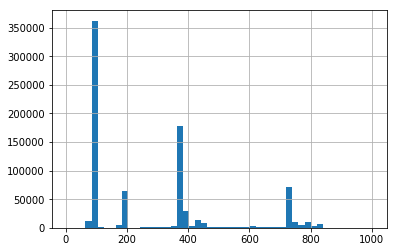

In [24]:
df[(df['benign'] == True) &(df['valid_duration'] > 0) & (df['valid_duration'] < 1000)]['valid_duration'].hist(bins=50)

In [ ]:
df.corr()